# Raw Images reduction 

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : 9 juin 2021
- Mise à jour, 10 juin 2021, 11 juin 2021,14 juin 2021
- Work
- inspired from Oliver viewimg

# Selection Flag

In [46]:
FLAG_SPRING_2021=False
FLAG_SUMMER_2021=True

In [47]:
from astropy.io import fits
import sys, platform, os
#from astropy.visualization import simple_norm
#from astropy.visualization import imshow_norm, MinMaxInterval, SqrtStretch
import astropy.visualization  as aspv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

In [48]:
def get_image_data(rep,num):
    dir_path = os.path.dirname(os.path.realpath(rep))
    end=str(num)+'.fits'
    print(end)
    filename='NOT_FOUND'
    for root, dirs, files in os.walk(dir_path):
        for filen in files:
            if filen.endswith(end):
                filename= filen

    if filename=='NOT_FOUND':
        return -99
    print(filename)

    hdulist = fits.open(rep+filename)
    data=hdulist[0].data

    hdulist.close()
    return data



In [49]:
def sub_med_hovc(data,ol,oh,ll,lh):
    sz=np.shape(data)[0]
    wd=np.shape(data)[1]
    newdat = np.zeros((sz-(oh-ol+1)-(lh-ll+1),wd))

    ovl=np.median(data[ol:oh+1,:],axis=0)
    ovh=np.median(data[ll:lh+1,:],axis=0)
    newdat[0:ol,:]=data[0:ol,:]-ovl#[:,np.newaxis]
    newdat[ol:,:]=data[lh+1:,:]-ovh#[:,np.newaxis]
    return newdat


In [50]:
def remove_vovc(data,losz,rosz,nov):
    sz=np.shape(data)[0]
    wd=np.shape(data)[1]

    osz=losz+rosz
    newl=wd-nov*(osz) #-1
    newdat = np.zeros((sz,newl))

    print("sz="+str(sz)+" wd="+str(wd)+" newl="+str(newl))
    print(osz)
    width = newl/8
    print(width)

    indx=(np.arange(newl)).astype('int')

    indx = indx + osz*((indx/width).astype('int')+1)-losz
    newdat=data[:,indx]
    return newdat

In [51]:
#1724 1791
def viewimg_raw(rep,num):
    z=get_image_data(rep,num)
    print(np.shape(z))
    sz=np.shape(z)
    zc=sub_med_hovc(z,2000,2047,2048,2095)

    zd=remove_vovc(zc,3,64,8)

    #plt.figure()
    #plt.imshow(z,aspect='auto',interpolation='none',cmap='gist_ncar')
    #plt.colorbar()
    plt.figure()
    plt.imshow(zc,aspect='auto',interpolation='none',cmap='gist_ncar')
    plt.colorbar()
    plt.figure()
    plt.imshow(zd,aspect='auto',interpolation='none',cmap='gist_ncar')
    plt.colorbar()
    print(np.shape(zd))

In [52]:
def viewimg_cln(rep,num):
    filename=get_name(rep,num)
    plt.figure(figsize=(13,9.5))
    if filename=='NOT_FOUND':
        return "unknown file"

    hdl=fits.open(rep+filename)
    zd=hdl[1].data
    norm = aspv.simple_norm(zd,stretch='sqrt')
    plt.imshow(zd,origin='lower',aspect='auto',interpolation='none',cmap='gist_ncar',norm=norm,vmin=-100,vmax=3100)
    plt.colorbar()
    print(repr(hdl[0].header))

In [53]:
def get_name(rep,num):
    dir_path = (os.path.realpath(rep))
    end=str(num)+'.fits'
    print(end)
    print(dir_path)
    filename='NOT_FOUND'
    for root, dirs, files in os.walk(dir_path):
        for filen in files:
            if filen.endswith(end):
                filename= filen
    print(filename)
    return filename


In [54]:
# loop over subdirs, may be wrong
def cor_img(rep,num,repsave):

    dir_path = os.path.dirname(os.path.realpath(rep))
    end=str(num)+'.fits'
    print(end)
    filename='NOT_FOUND'
    for root, dirs, files in os.walk(dir_path):
        for filen in files:
            if filen.endswith(end):
                filename= filen

    if filename=='NOT_FOUND':
        return -99
    print(filename)

    hdulist = fits.open(rep+filename)
    hh=hdulist[0].header


    z=hdulist[0].data
    hdulist.close()
    sz=np.shape(z)
    zc=sub_med_hovc(z,2000,2047,2048,2095)

    zd=remove_vovc(zc,3,64,8)
    #sp=np.shape(zd)
    del hh['DATASEC']
    #hh['NAXIS1']=sp[1]
    #hh['NAXIS2']=sp[0]

    hh.set('HA', hh['HASTART'])

    print(repr(hh))
    print (" ---> ")
    hdui = fits.ImageHDU(np.flip(zd,axis=0))
    hdu = fits.PrimaryHDU()
    nhd=hdu.header
    
    for hk in hh[5:] :
        if hk != 'COMMENT':
            nhd.set(hk,hh[hk])
    print(repr(nhd))

    #   hdu.writeto(repsave+"Cor_"+filename,overwrite=True)
    new_hdul = fits.HDUList([hdu, hdui])
    new_hdul.writeto(repsave+"Cor_"+filename,overwrite=True)
    return 0


In [55]:
# does not loop over subdirs
def cor_img_v2(rep,num,repsave):

    #dir_path = os.path.dirname(os.path.realpath(rep))
    dir_path = rep
    end=str(num)+'.fits'
    
    print(end)
    filename='NOT_FOUND'
    for root, dirs, files in os.walk(dir_path):
        print("dir_path = ",dir_path)   
        print("root=",root)
        print("dirs=",dirs)
        
        for filen in files:
            if filen.endswith(end):
                filename= filen

    if filename=='NOT_FOUND':
        return -99
    print(filename)

    hdulist = fits.open(rep+filename)
    hh=hdulist[0].header


    z=hdulist[0].data
    print("z.shape=",z.shape)
    hdulist.close()
    
    
    sz=np.shape(z)
    zc=sub_med_hovc(z,2000,2047,2048,2095)
    zd=remove_vovc(zc,3,64,8)
    
    
    #sp=np.shape(zd)
    del hh['DATASEC']
    #hh['NAXIS1']=sp[1]
    #hh['NAXIS2']=sp[0]

    hh.set('HA', hh['HASTART'])

    #print(repr(hh))
    #print (" ---> ")
    
    
    hdui = fits.ImageHDU(np.flip(zd,axis=0))
    hdu = fits.PrimaryHDU()
    
    nhd=hdu.header
    
    for hk in hh[5:] :
        if hk != 'COMMENT':
            nhd.set(hk,hh[hk])
    print(repr(nhd))

    #   hdu.writeto(repsave+"Cor_"+filename,overwrite=True)
    new_hdul = fits.HDUList([hdu, hdui])
    new_hdul.writeto(repsave+"Cor_"+filename,overwrite=True)
    return 0


# Work

## Spring 2021

In [56]:
if FLAG_SPRING_2021:
    day_one='2021_02_17/'
    indx=np.arange(9).astype('int')+350
    for id in indx :
        cor_img(day_one,id,'/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans/')

    day_two='2021_02_18/'
    indx=np.arange(33).astype('int')+556
    for id in indx :
        cor_img(day_two,id,'/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans/')

    day_3='/sps/lsst/groups/auxtel/data/2021/holo/2021_02_16/raw/'
    indx=np.arange(55).astype('int')+155
    for id in indx :
        cor_img(day_3,id,'/sps/lsst/groups/auxtel/data/2021/holo/FlipCleans/')

# Summer 2021

In [57]:
if FLAG_SUMMER_2021:
    intputdir_day_1="/sps/lsst/groups/auxtel/data/2021/holo/raw/2021-06-08/"
    outputdir_day_1="/sps/lsst/groups/auxtel/data/2021/holo/localreduced/2021-06-08/"
    
    intputdir_day_2="/sps/lsst/groups/auxtel/data/2021/holo/raw/2021-06-10/"
    outputdir_day_2="/sps/lsst/groups/auxtel/data/2021/holo/localreduced/2021-06-10/"
    
    
    intputdir_day_3="/sps/lsst/groups/auxtel/data/2021/micellanous/raw/2021-06-08/"
    outputdir_day_3="/sps/lsst/groups/auxtel/data/2021/micellanous/localreduced/2021-06-08/"
    
    #list_of_files=os.listdir(intputdir_day_1)
    #list_of_files=os.listdir(intputdir_day_2)
    list_of_files=os.listdir(intputdir_day_3)
    

In [58]:
! ls /sps/lsst/groups/auxtel/data/2021/micellanous/raw/2021-06-08

empty_1_BG40_slew_icrs_20210608_000361.fits
empty_1_BG40_slew_icrs_20210608_000362.fits
empty_1_BG40_slew_icrs_20210608_000363.fits
empty_1_empty_slew_icrs_20210608_000364.fits
holo4_003_BG40_slew_icrs_20210608_000368.fits
holo4_003_BG40_slew_icrs_20210608_000369.fits
holo4_003_BG40_slew_icrs_20210608_000370.fits
holo4_003_empty_slew_icrs_20210608_000371.fits
holo4_003_empty_slew_icrs_20210608_000372.fits
holo4_003_empty_slew_icrs_20210608_000373.fits
holo4_003_RG610_slew_icrs_20210608_000365.fits
holo4_003_RG610_slew_icrs_20210608_000366.fits
holo4_003_RG610_slew_icrs_20210608_000367.fits


In [59]:
! ls /sps/lsst/groups/auxtel/data/2021/micellanous/localreduced/2021-06-08

In [60]:
list_of_files.sort()
list_of_files

['empty_1_BG40_slew_icrs_20210608_000361.fits',
 'empty_1_BG40_slew_icrs_20210608_000362.fits',
 'empty_1_BG40_slew_icrs_20210608_000363.fits',
 'empty_1_empty_slew_icrs_20210608_000364.fits',
 'holo4_003_BG40_slew_icrs_20210608_000368.fits',
 'holo4_003_BG40_slew_icrs_20210608_000369.fits',
 'holo4_003_BG40_slew_icrs_20210608_000370.fits',
 'holo4_003_RG610_slew_icrs_20210608_000365.fits',
 'holo4_003_RG610_slew_icrs_20210608_000366.fits',
 'holo4_003_RG610_slew_icrs_20210608_000367.fits',
 'holo4_003_empty_slew_icrs_20210608_000371.fits',
 'holo4_003_empty_slew_icrs_20210608_000372.fits',
 'holo4_003_empty_slew_icrs_20210608_000373.fits']

In [61]:
all_num = []

for filename in list_of_files:
    num=filename.split("_")[-1].split(".")[0]
    all_num.append(num)
    
all_num=np.array(all_num)

In [62]:
all_num.sort()

In [63]:
all_num

array(['000361', '000362', '000363', '000364', '000365', '000366',
       '000367', '000368', '000369', '000370', '000371', '000372',
       '000373'], dtype='<U6')

In [64]:
len(all_num)

13

In [65]:
for num in all_num:
    #cor_img(intputdir_day_1,num,outputdir_day_1)
    
    print("================================", num,"=========================================")
    cor_img_v2(intputdir_day_3,num,outputdir_day_3)

================================ 000361 =========================================
000361.fits
dir_path =  /sps/lsst/groups/auxtel/data/2021/micellanous/raw/2021-06-08/
root= /sps/lsst/groups/auxtel/data/2021/micellanous/raw/2021-06-08/
dirs= []
empty_1_BG40_slew_icrs_20210608_000361.fits
z.shape= (4096, 4608)
sz=4000 wd=4608 newl=4072
67
509.0
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
ORIGIN  = 'LSST DM Header Service'                                              
TIMESYS = 'TAI     '                                                            
DATE    = '2021-06-09T03:45:27.996'                                             
DATE-OBS= '2021-06-09T03:46:00.124'                                             
DATE-B

In [72]:
dir_path = os.path.dirname(os.path.realpath(intputdir_day_2))
print(os.walk(dir_path))

<generator object walk at 0x7fd8a93ab890>


In [73]:

rep=intputdir_day_3
dir_path = os.path.dirname(os.path.realpath(rep))
dir_path=rep
#end=str(num)+'.fits'
end='.fits'
#print(end)
filename='NOT_FOUND'
for root, dirs, files in os.walk(dir_path):
    print("root=",root)
    print("dirs=",dirs)
    print("files=",files)
    for filen in files:
        if filen.endswith(end):
            filename= filen
            break

#if filename=='NOT_FOUND':
#    return -99
print("filename=",filename)

hdulist = fits.open(rep+filename)
hh=hdulist[0].header


z=hdulist[0].data
print("z.shape=",z.shape)
hdulist.close()
    

root= /sps/lsst/groups/auxtel/data/2021/micellanous/raw/2021-06-08/
dirs= []
files= ['holo4_003_BG40_slew_icrs_20210608_000369.fits', 'holo4_003_RG610_slew_icrs_20210608_000365.fits', 'holo4_003_empty_slew_icrs_20210608_000372.fits', 'holo4_003_RG610_slew_icrs_20210608_000367.fits', 'holo4_003_empty_slew_icrs_20210608_000373.fits', 'empty_1_BG40_slew_icrs_20210608_000361.fits', 'holo4_003_BG40_slew_icrs_20210608_000370.fits', 'empty_1_BG40_slew_icrs_20210608_000362.fits', 'holo4_003_empty_slew_icrs_20210608_000371.fits', 'holo4_003_RG610_slew_icrs_20210608_000366.fits', 'empty_1_empty_slew_icrs_20210608_000364.fits', 'empty_1_BG40_slew_icrs_20210608_000363.fits', 'holo4_003_BG40_slew_icrs_20210608_000368.fits']
filename= holo4_003_BG40_slew_icrs_20210608_000369.fits
z.shape= (4096, 4608)


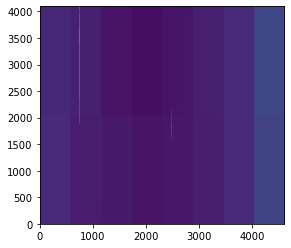

In [74]:
plt.imshow(z,origin="lower",norm=LogNorm())

In [75]:
sz=np.shape(z)
zc=sub_med_hovc(z,2000,2047,2048,2095)
zd=remove_vovc(zc,3,64,8)

sz=4000 wd=4608 newl=4072
67
509.0


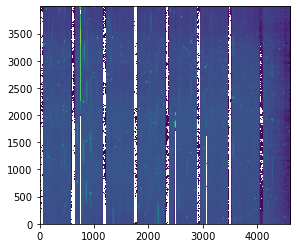

In [76]:
plt.imshow(zc,origin="lower",norm=LogNorm())

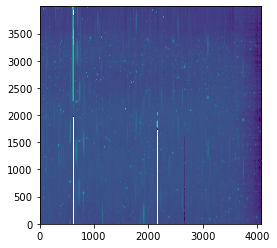

In [77]:
plt.imshow(zd,origin="lower",norm=LogNorm())